<a href="https://colab.research.google.com/github/aminfadaei116/Deep-Learning-Course/blob/master/CA2/Q1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import cv2
from scipy.io import loadmat
import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

In [ ]:
normalized_joint_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/normalized_joint_tensor.pt')
joint_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/joint_tensor.pt')
img_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/img_tensor.pt')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
normalized_joint_tensor = normalized_joint_tensor.to(device)
joint_tensor = joint_tensor.to(device)
img_tensor = img_tensor.to(device)

We now define all the needed libraries


In [ ]:
# makes it easy to write user-friendly command-line interfaces
import argparse
# contains data structures for multi-dimensional tensors
# and mathematical operations over theme
import torch
# helps us in creating and training of the neural network.
import torch.nn as nn
# contains all the functions in the torch.nn library
import torch.nn.functional as F
# implements various optimization algorithms
import torch.optim as optim
# contains datasets with almost similar API
from torchvision import datasets
# contains common image transformations
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# provides several methods to adjust the learning rate based on the number of epochs
from torch.optim.lr_scheduler import StepLR
NUMBER_JOINST = 14
NUMBER_DIM = 2

In [ ]:
class POS_IMG(Dataset):
  def __init__(self, img, norm_joint):
    self.img_data = img.view(-1, 3, 220, 220)
    self.img_joint = norm_joint
    self.length = norm_joint.shape[0]

  def __getitem__(self, index):
    return self.img_data[index], self.img_joint[index]

  def __len__(self):
    return self.length


In [ ]:
DataLength = img_tensor.shape[0]
MyTrainDataSet = POS_IMG(img_tensor[0:int(DataLength*0.7)], normalized_joint_tensor[0:int(DataLength*0.7)])
MyValidactionDataSet = POS_IMG(img_tensor[int(DataLength*0.7):int(DataLength*0.85)], normalized_joint_tensor[int(DataLength*0.7):int(DataLength*0.85)])
MyTestDataSet = POS_IMG(img_tensor[int(DataLength*0.85):], normalized_joint_tensor[int(DataLength*0.85):])

BATCH_SIZE = 128
TrainData = torch.utils.data.DataLoader(dataset=MyTrainDataSet, batch_size=BATCH_SIZE, shuffle=True)
ValidationData = torch.utils.data.DataLoader(dataset=MyValidactionDataSet)
TestData = torch.utils.data.DataLoader(dataset=MyTestDataSet)


And Here we define the class of the network

In [ ]:
class CNN_Net(nn.Module):
  def __init__(self):
    self.loss_graphT = []
    self.loss_graphV = []
    self.loss_graphTest = []
    self.PCP_graphT = []
    self.PCP_graphV = []
    self.PDJ_graphT = []
    self.PDJ_graphV = []
    self.PCP_graphTest = []
    self.PDJ_graphTest = []

    super(CNN_Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=4)
    self.LRN1 =  nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
    self.MP1 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5,padding=2)
    self.LRN2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
    self.MP2 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
    self.MP3 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.D1 = nn.Dropout(p=0.6, inplace=True)
    self.fc1 = nn.Linear(in_features=(256 * 6 * 6), out_features=4096)
    self.D2 = nn.Dropout(p=0.6, inplace=True)
    self.fc2 = nn.Linear(in_features=(4096), out_features=4096)
    self.fc3 = nn.Linear(in_features=(4096), out_features=NUMBER_JOINST * NUMBER_DIM)



  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.LRN1(x)
    x = self.MP1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.LRN2(x)
    x = self.MP2(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.MP3(x)
    x = x.view(-1, 256 * 6 * 6)
    x = self.D1(x)
    x = F.relu((self.fc1(x)))
    x = self.D2(x)
    x = F.relu((self.fc2(x)))
    x = (self.fc3(x))
    return x

  def Train_net(self, learning_rate, epoch_number):
    self.train()
    optimizer = optim.Adam(MyNetwork.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    EPOCHS = epoch_number
    self.loss_graphV.append(self.Cal_loss_accV(MyValidactionDataSet))
    self.loss_graphTest.append(self.Cal_loss_accT(MyTestDataSet))
    for epoch in range(EPOCHS):
      for i, (inputs, labels) in enumerate(TrainData):
        batch_X = inputs
        batch_Y = labels.view(-1,28)
        optimizer.zero_grad()
        output = MyNetwork(batch_X)
        self.PDJ_graphT.append(self.PDJ_cal(batch_Y, output, inputs.shape[0]))
        self.PCP_graphT.append(self.PCP_cal(labels, output, inputs.shape[0]))
        loss = loss_function(output, batch_Y)
        self.loss_graphT.append(loss.item())
        l1 = 0
        for p in self.parameters():
          l1 = l1 + p.abs().sum()
        loss = loss + 0.00000001 * l1
        loss.backward()
        optimizer.step()
        print("epoch: ", epoch, " loss for batch: ", loss)
      self.loss_graphV.append(self.Cal_loss_accV(MyValidactionDataSet))
      self.loss_graphTest.append(self.Cal_loss_accT(MyTestDataSet))
      
  def PCP_cal(self, true_joint, pred_joint, batch_S):
    pred_joint = pred_joint.view(-1, 2, 14)
    TLL1 = torch.norm(true_joint[:,:,0] - true_joint[:,:,1], p=2, dim=1) 
    TLL2 = torch.norm(true_joint[:,:,1] - true_joint[:,:,2], p=2, dim=1) 
    TLL3 = torch.norm(true_joint[:,:,2] - true_joint[:,:,3], p=2, dim=1) 
    TLL4 = torch.norm(true_joint[:,:,3] - true_joint[:,:,4], p=2, dim=1) 
    TLL5 = torch.norm(true_joint[:,:,4] - true_joint[:,:,5], p=2, dim=1) 
    TLL6 = torch.norm(true_joint[:,:,6] - true_joint[:,:,7], p=2, dim=1) 
    TLL7 = torch.norm(true_joint[:,:,7] - true_joint[:,:,8], p=2, dim=1) 
    TLL8 = torch.norm(true_joint[:,:,8] - true_joint[:,:,9], p=2, dim=1) 
    TLL9 = torch.norm(true_joint[:,:,9] - true_joint[:,:,10], p=2, dim=1) 
    TLL10 = torch.norm(true_joint[:,:,10] - true_joint[:,:,11], p=2, dim=1) 
    TLL11 = torch.norm(true_joint[:,:,12] - true_joint[:,:,13], p=2, dim=1) 
    TC1 = (true_joint[:,:,0] + true_joint[:,:,1])/2
    TC2 = (true_joint[:,:,1] + true_joint[:,:,2])/2
    TC3 = (true_joint[:,:,2] + true_joint[:,:,3])/2
    TC4 = (true_joint[:,:,3] + true_joint[:,:,4])/2
    TC5 = (true_joint[:,:,4] + true_joint[:,:,5])/2
    TC6 = (true_joint[:,:,6] + true_joint[:,:,7])/2
    TC7 = (true_joint[:,:,7] + true_joint[:,:,8])/2
    TC8 = (true_joint[:,:,8] + true_joint[:,:,9])/2
    TC9 = (true_joint[:,:,9] + true_joint[:,:,10])/2
    TC10 = (true_joint[:,:,10] + true_joint[:,:,11])/2
    TC11 = (true_joint[:,:,12] + true_joint[:,:,13])/2
    PC1 = (pred_joint[:,:,0] + pred_joint[:,:,1])/2
    PC2 = (pred_joint[:,:,1] + pred_joint[:,:,2])/2
    PC3 = (pred_joint[:,:,2] + pred_joint[:,:,3])/2
    PC4 = (pred_joint[:,:,3] + pred_joint[:,:,4])/2
    PC5 = (pred_joint[:,:,4] + pred_joint[:,:,5])/2
    PC6 = (pred_joint[:,:,6] + pred_joint[:,:,7])/2
    PC7 = (pred_joint[:,:,7] + pred_joint[:,:,8])/2
    PC8 = (pred_joint[:,:,8] + pred_joint[:,:,9])/2
    PC9 = (pred_joint[:,:,9] + pred_joint[:,:,10])/2
    PC10 = (pred_joint[:,:,10] + pred_joint[:,:,11])/2
    PC11 = (pred_joint[:,:,12] + pred_joint[:,:,13])/2
    dist1 = torch.norm(TC1 - PC1, p=2, dim=1)
    dist2 = torch.norm(TC2 - PC2, p=2, dim=1)
    dist3 = torch.norm(TC3 - PC3, p=2, dim=1)
    dist4 = torch.norm(TC4 - PC4, p=2, dim=1)
    dist5 = torch.norm(TC5 - PC5, p=2, dim=1)
    dist6 = torch.norm(TC6 - PC6, p=2, dim=1)
    dist7 = torch.norm(TC7 - PC7, p=2, dim=1)
    dist8 = torch.norm(TC8 - PC8, p=2, dim=1)
    dist9 = torch.norm(TC9 - PC9, p=2, dim=1)
    dist10 = torch.norm(TC10 - PC10, p=2, dim=1)
    dist11 = torch.norm(TC11 - PC11, p=2, dim=1)
    dist1[dist1 < TLL1/2] = 0
    dist2[dist2 < TLL2/2] = 0
    dist3[dist3 < TLL3/2] = 0
    dist4[dist4 < TLL4/2] = 0
    dist5[dist5 < TLL5/2] = 0
    dist6[dist6 < TLL6/2] = 0
    dist7[dist7 < TLL7/2] = 0
    dist8[dist8 < TLL8/2] = 0
    dist9[dist9 < TLL9/2] = 0
    dist10[dist10 < TLL10/2] = 0
    dist11[dist11 < TLL11/2] = 0
    count = 0
    count += (dist1==0).sum()
    count += (dist2==0).sum()
    count += (dist3==0).sum()
    count += (dist4==0).sum()
    count += (dist5==0).sum()
    count += (dist6==0).sum()
    count += (dist7==0).sum()
    count += (dist8==0).sum()
    count += (dist9==0).sum()
    count += (dist10==0).sum()
    count += (dist11==0).sum()
    return 100 * count / (batch_S * 11)


  def PDJ_cal(self, true_joint, pred_joint, batch_S):
    joint_threshold = 0.5
    temp1 = true_joint[:, 2] - true_joint[:, 9]
    temp2 = true_joint[:, 16] - true_joint[:, 23]
    dist = temp1 * temp1 + temp2 * temp2
    diff = true_joint - pred_joint
    diff = diff * diff
    diff = diff.view(-1,2,14)
    diff = torch.sum(diff, dim=1)
    binary_dist = diff - joint_threshold * dist[:, None]
    binary_dist[binary_dist < 0] = 0
    return 100 * (binary_dist==0).sum() / (batch_S * 14)


  def Cal_loss_accV(self, Current_DataSet):
    MyNetwork.eval()
    loss_function = nn.MSELoss()
    with torch.no_grad():
      batch_X = Current_DataSet[:][0]
      batch_Y = Current_DataSet[:][1].view(-1,28)
      output = MyNetwork(batch_X) 
      loss = loss_function(output, batch_Y)
      self.PDJ_graphV.append(self.PDJ_cal(batch_Y, output, batch_X.shape[0]))
      self.PCP_graphV.append(self.PCP_cal(Current_DataSet[:][1], output, batch_X.shape[0]))
    current_loss = loss.item()
    print("The Validation Loss: ", current_loss)
    return current_loss

  def Cal_loss_accT(self, Current_DataSet):
    MyNetwork.eval()
    loss_function = nn.MSELoss()
    with torch.no_grad():
      batch_X = Current_DataSet[:][0]
      batch_Y = Current_DataSet[:][1].view(-1,28)
      output = MyNetwork(batch_X) 
      loss = loss_function(output, batch_Y)
      self.PDJ_graphTest.append(self.PDJ_cal(batch_Y, output, batch_X.shape[0]))
      self.PCP_graphTest.append(self.PCP_cal(Current_DataSet[:][1], output, batch_X.shape[0]))
    current_loss = loss.item()
    print("The Test Loss: ", current_loss)
    return current_loss

  def Test_single(self, number, Current_DataSet):
    MyNetwork.eval()
    with torch.no_grad():
      predicted_joints = MyNetwork.forward(Current_DataSet[number:number+1][0]).view(-1,2,14)
      real_joints =  (Current_DataSet[number:number+1][1])
      plt.imshow(Current_DataSet[number][0].view(220, 220, 3).cpu().detach().numpy()/256)
      x1 = predicted_joints[0][0].cpu().detach().numpy()
      y1 = predicted_joints[0][1].cpu().detach().numpy()
      y1 = np.multiply(y1, 220)
      x1 = np.multiply(x1, 220)
      x1 = np.add(x1, 110)
      y1 = np.add(y1, 110)
      plt.scatter(x1, y1, c="red")
      plt.plot(x1[0:2], y1[0:2], c='b')
      plt.plot(x1[1:3], y1[1:3], c='r')
      plt.plot(x1[3:5], y1[3:5], c='r')
      plt.plot(x1[4:6], y1[4:6], c='b')

      plt.plot(x1[6:8], y1[6:8], c='g')
      plt.plot(x1[7:9], y1[7:9], c='y')
      plt.plot(x1[8:10], y1[8:10], c='r')
      plt.plot(x1[9:11], y1[9:11], c='y')
      plt.plot(x1[10:12], y1[10:12], c='g')

      plt.plot(x1[12:14], y1[12:14], c='m')

      plt.show()

  def plot_res(self):
    plt.plot(np.arange(1,len(self.loss_graphT)+1), self.loss_graphT)
    plt.ylabel('loss of Train')
    plt.xlabel("number steps")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.loss_graphV)+1), self.loss_graphV)
    plt.ylabel('loss of validation')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.loss_graphTest)+1), self.loss_graphTest)
    plt.ylabel('loss of Test')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.PCP_graphT)+1), self.PCP_graphT)
    plt.ylabel('PCP of training Data')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.PDJ_graphT)+1), self.PDJ_graphT)
    plt.ylabel('PDJ of tarining Data')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.PCP_graphV)+1), self.PCP_graphV)
    plt.ylabel('PCP of Validation Data')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.PDJ_graphV)+1), self.PDJ_graphV)
    plt.ylabel('PDJ of Validation Data')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.PCP_graphTest)+1), self.PCP_graphTest)
    plt.ylabel('PCP of Test Data')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()
    plt.plot(np.arange(1,len(self.PDJ_graphTest)+1), self.PDJ_graphTest)
    plt.ylabel('PDJ of Test Data')
    plt.xlabel("number epochs")
    plt.grid(True)
    plt.show()

In [ ]:
MyNetwork = CNN_Net()
MyNetwork.to(device)

CNN_Net(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (LRN1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (MP1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LRN2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
  (MP2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (MP3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (D1): Dropout(p=0.6, inplace=True)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (D2): Dropout(p=0.6, inplace=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_fea

In [ ]:
MyNetwork.Train_net(learning_rate=0.00005, epoch_number=8)

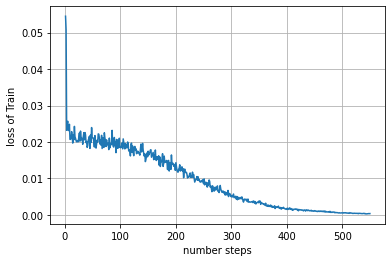

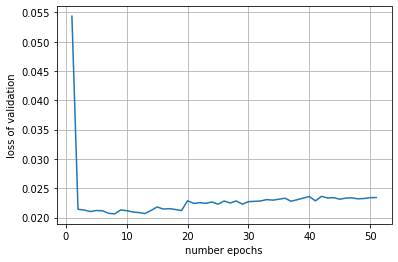

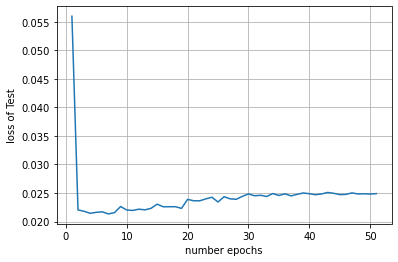

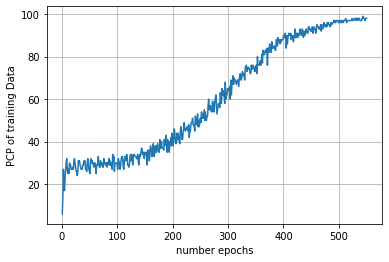

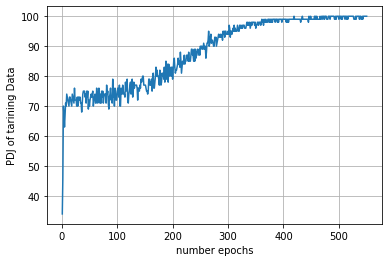

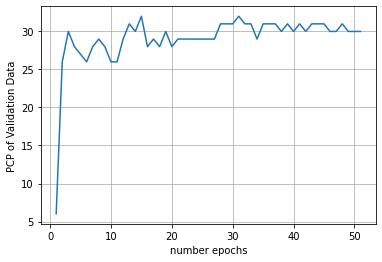

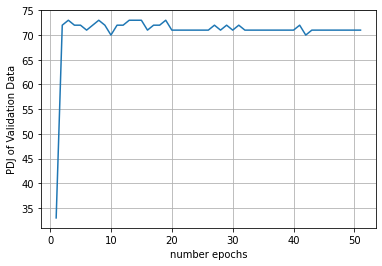

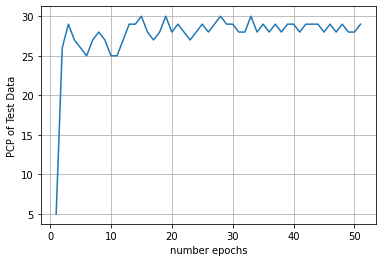

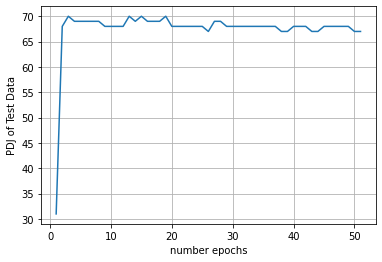

In [ ]:
MyNetwork.plot_res()

In [ ]:
MyNetwork.Test_single(10, MyTrainDataSet)